In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH
)

In [2]:
df = pd.read_csv("/home/andres/data/hbmep-processed/L_CIRC/data.csv")
config = Config(toml_path=TOML_PATH)
model = NonHierarchicalBayesianModel(config=config)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
src = "/home/andres/repos/rat-mapping-paper/reports/L_CIRC/combine_response.pkl"
with open(src, "rb") as f:
    combinations = pickle.load(f)

In [4]:
subjects = sorted(df['participant'].unique())
configuration = ['Vertex', 'Radius', 'Diameter']
electrodes = sorted(df['compound_position'].unique())
muscles = model.response


In [5]:
electrodes

['-C6LC',
 '-C6LE',
 '-C6LN',
 '-C6LNE',
 '-C6LNW',
 '-C6LS',
 '-C6LSE',
 '-C6LSW',
 '-C6LW',
 'C6LE-C6LC',
 'C6LE-C6LW',
 'C6LN-C6LC',
 'C6LNE-C6LC',
 'C6LNE-C6LSW',
 'C6LNW-C6LC',
 'C6LS-C6LC',
 'C6LS-C6LN',
 'C6LSE-C6LC',
 'C6LSE-C6LNW',
 'C6LSW-C6LC',
 'C6LW-C6LC']

In [6]:
vertices = [e for e in electrodes if e.split('-')[0] == '']
vertices


['-C6LC',
 '-C6LE',
 '-C6LN',
 '-C6LNE',
 '-C6LNW',
 '-C6LS',
 '-C6LSE',
 '-C6LSW',
 '-C6LW']

In [7]:
radii = [e for e in electrodes if e.split('-')[1] == 'C6LC' and e != '-C6LC']
radii

['C6LE-C6LC',
 'C6LN-C6LC',
 'C6LNE-C6LC',
 'C6LNW-C6LC',
 'C6LS-C6LC',
 'C6LSE-C6LC',
 'C6LSW-C6LC',
 'C6LW-C6LC']

In [8]:
diameters = set(electrodes) - (set(vertices) | set(radii))
diameters = list(diameters)
diameters

['C6LSE-C6LNW', 'C6LNE-C6LSW', 'C6LE-C6LW', 'C6LS-C6LN']

In [9]:
ord = []
arr = []
mask = []
for sub in subjects:
    for config in configuration:
        for elec in electrodes:
            for m in muscles:
                flag = False

                if config == 'Vertex' and elec in vertices:
                    flag = True
                elif config == 'Radius' and elec in radii:
                    flag = True
                elif config == 'Diameter' and elec in diameters:
                    flag = True
                else:
                    flag = False
                
                if flag:
                    position = elec
                    key = (sub, position, m)
                    tcomb = combinations[key]['response']
                    tcomb = tcomb.reshape(-1, 1)

                    arr.append(tcomb)
                    mask.append(np.full((1000,1), False))

                else:
                    arr.append(np.zeros(1000).reshape(-1, 1))
                    mask.append(np.full((1000, 1), True))                



                    
arr = np.array(arr)
arr = arr.reshape(len(subjects), len(configuration),len(electrodes), len(muscles), *arr.shape[1:])
mask = np.array(mask)
mask = mask.reshape(len(subjects), len(configuration),len(electrodes),len(muscles), *mask.shape[1:])

arr = ma.masked_array(arr, mask=mask)
arr = arr[..., 0]
                

In [10]:
#Specify Vertex [0] / Radius [1] / Diameter [2]
target_config = 2
#Specify Rat
sub_id = 0

#Normalize based on max, then calculate ratio
curr_y = arr[:, target_config, ...]         # (8, 21, 6, 1000)
curr_y_max = ma.max(curr_y, axis=(1, 3), keepdims=True)     # (8, 1, 6, 1)
y = curr_y / curr_y_max
ratio_y = y / y.sum(axis = -2, keepdims = True)

#Calculate entropy
numerator = (ratio_y * ma.log(ratio_y)).sum(axis=-2)
denominator = np.log(len(model.response))
entropy = 1 + (numerator / denominator)

# entropy = 1+(((ratio_y * np.log2(ratio_y)).sum(axis = -2))/ np.log2(len(model.response)))
entropy_max = ma.max(entropy, axis = -1)
entropy_max.shape

(8, 21)

In [29]:
df['participant'].unique()

array(['amap01', 'amap02', 'amap03', 'amap04', 'amap05', 'amap06',
       'amap07', 'amap08'], dtype=object)

In [31]:
subjects[1]

'amap02'

In [11]:
entropy_max.mask[0, :].sum()

17

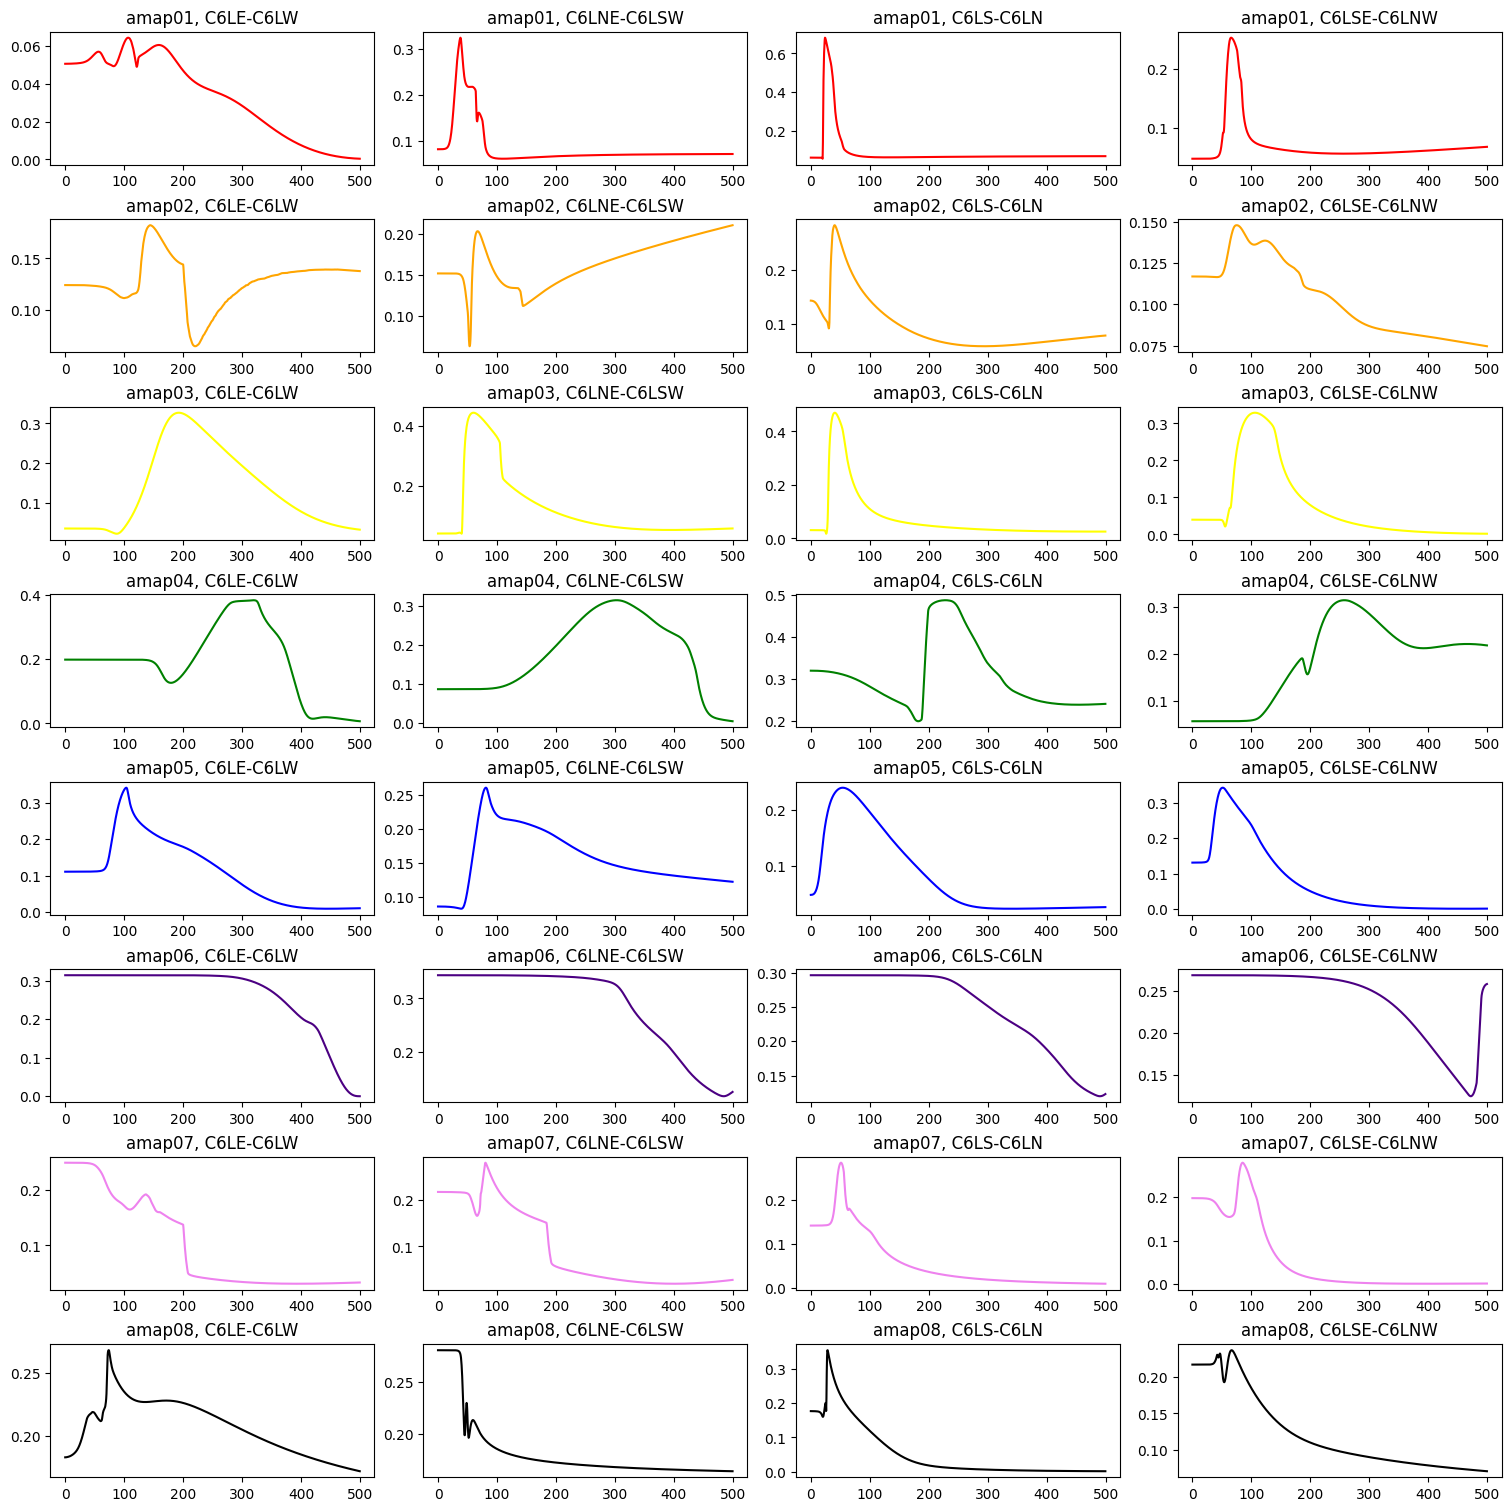

In [35]:
subject = 0

nrows = 8
ncols = (~entropy_max.mask[subject, :]).sum()
colors = {0:'red', 1:'orange', 2:'yellow', 3:'green', 4:'blue', 5:'indigo', 6:'violet', 7:'black'}

fig, axes = plt.subplots(
    nrows, ncols, constrained_layout=True, squeeze=False,figsize=(15, 15)
)

for s, sub in enumerate(subjects):
    j = 0
    sub_id = subjects[s]
    for i, electrode in enumerate(electrodes):
        if entropy_max.mask[s, i]:
            continue

        else:
            ax = axes[s, j]
            # Logic to plot
            sns.lineplot(x=np.arange(0, 500, .5), y=entropy[s, i], ax=ax, color=colors[s])
            # ax.plot(entropy[s, i], color = colors[s])
            ax.set_title(f"{sub_id}, {electrode}")
            j += 1


<function matplotlib.pyplot.show(close=None, block=None)>

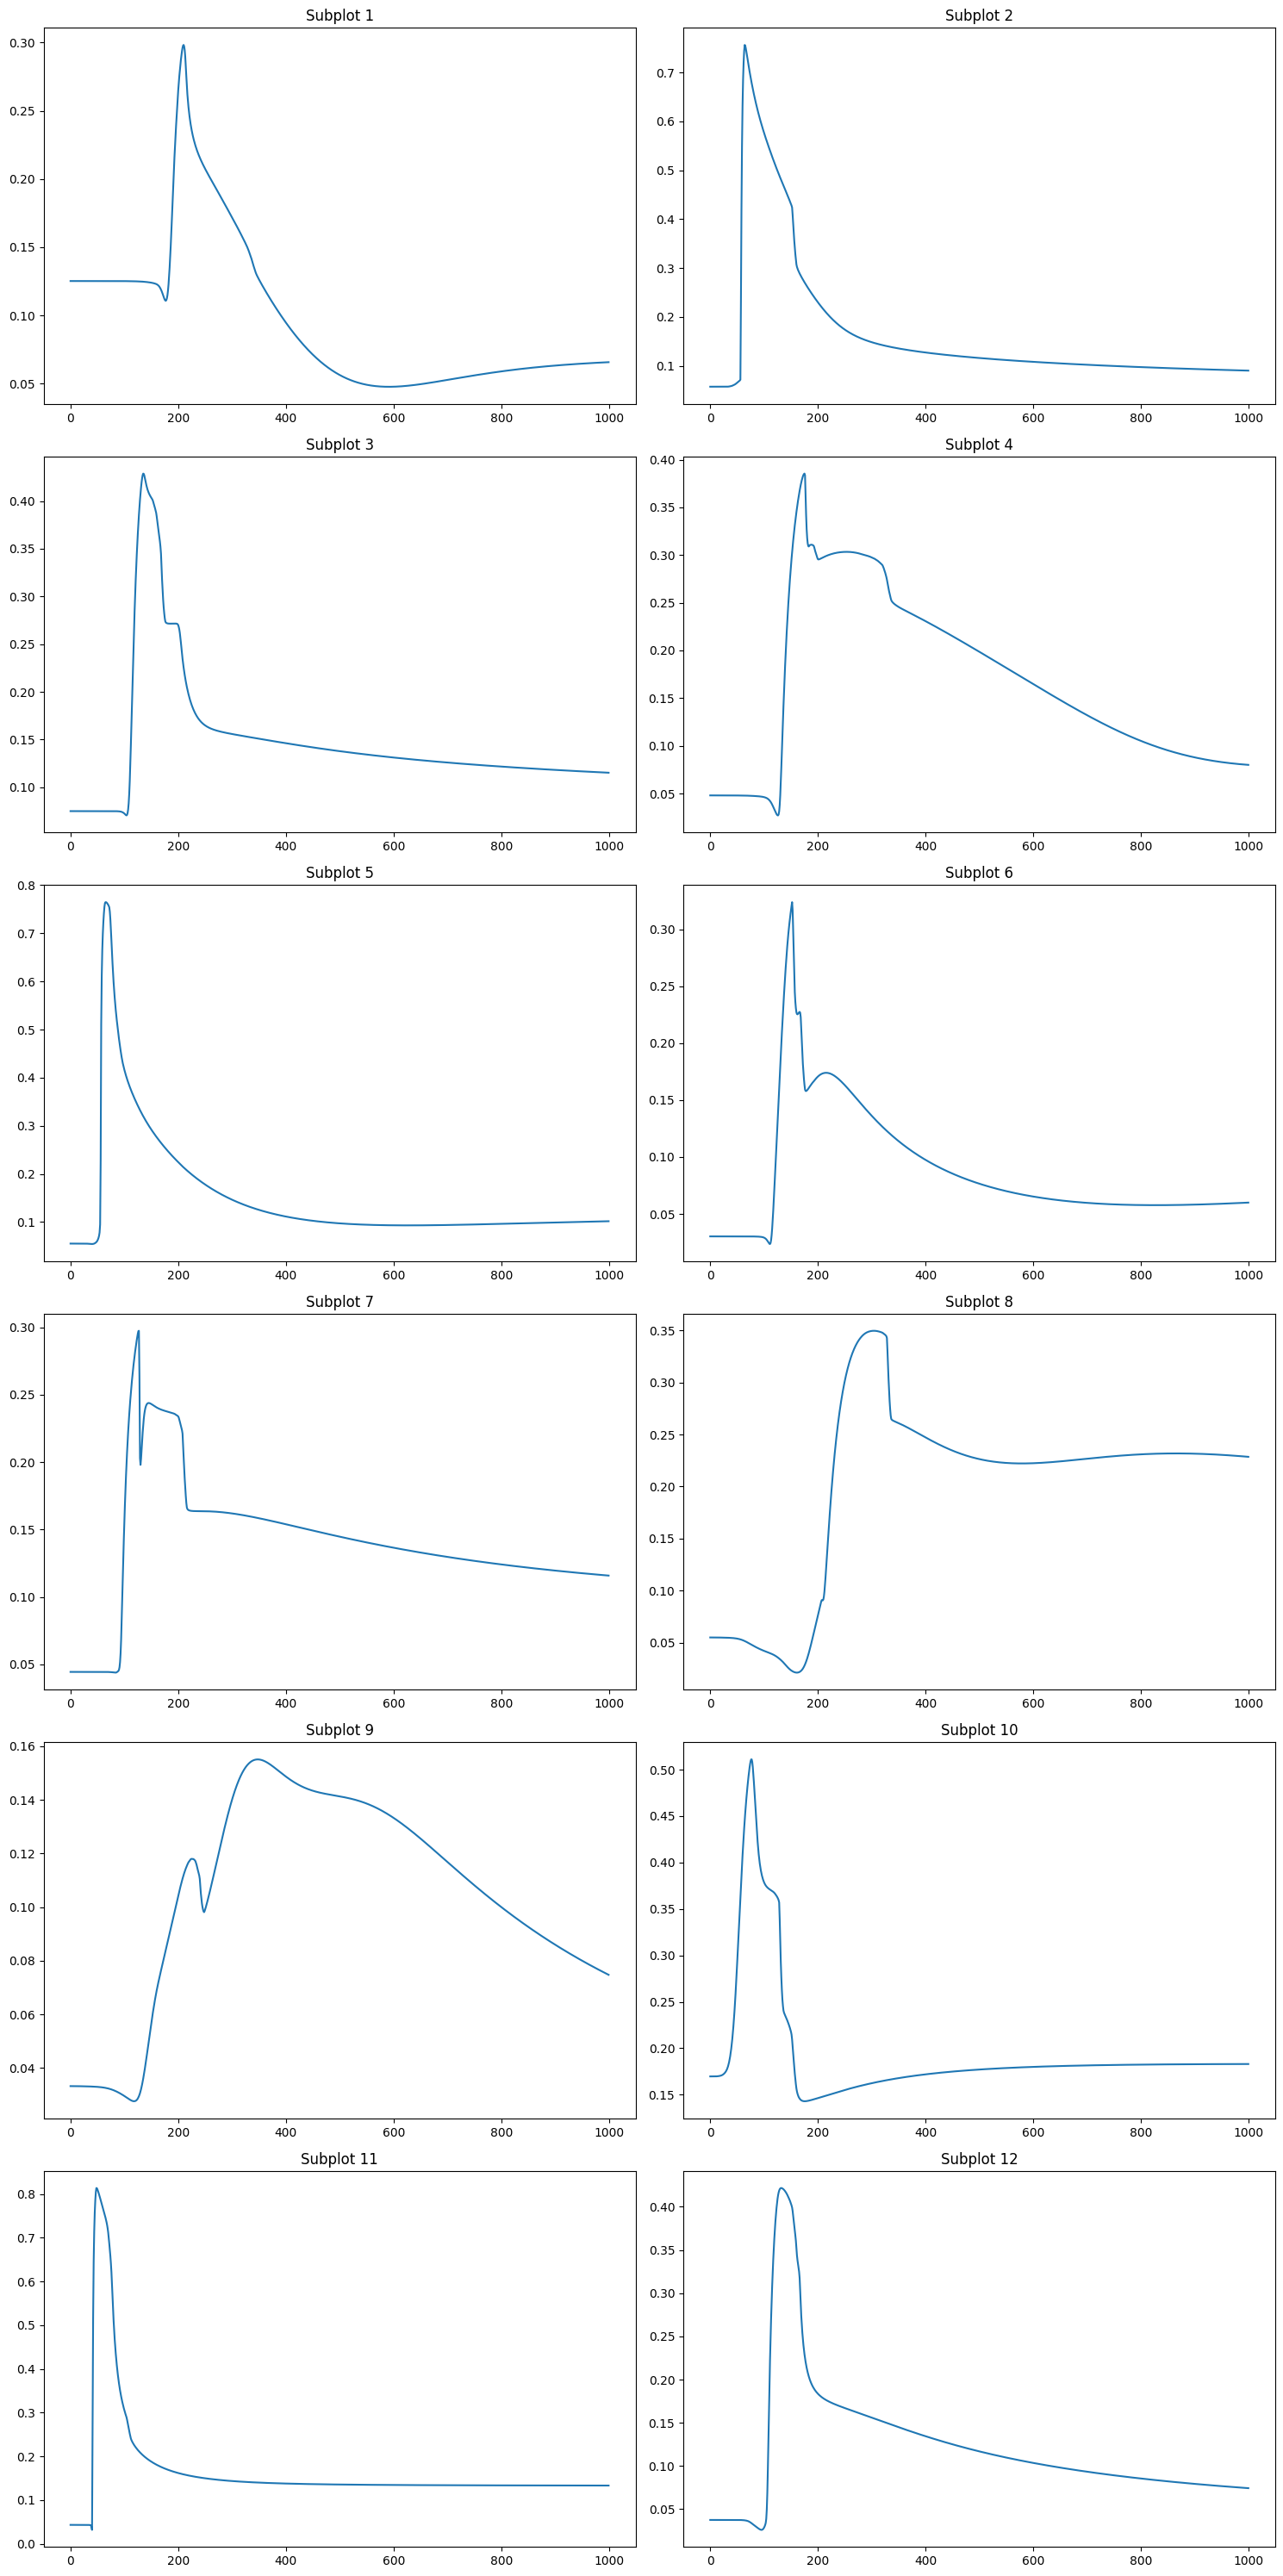

In [143]:
#Filter to find only valid electrode combinations along 21 dimension
valid_ind = np.any(entropy > 0, axis = (0,-1))
filtered_data = entropy[:,valid_ind,:]
num_valid = filtered_data.shape[1]
ncols = 2
nrows = (num_valid + ncols - 1) // ncols

#Plot only valid combinations
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axs = axs.flatten()

for i in range(num_valid):
    axs[i].plot(filtered_data[sub_id,i])
    axs[i].set_title(f'Subplot {i+1}')
for j in range(num_valid, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show

In [114]:
entropy_max[1]

masked_array(data=[0.0, 0.6975750814339144, 0.1837466655644865,
                   0.1339579315386803, 0.31660161788369856,
                   0.26894627453325326, 0.26680317092180217,
                   0.21769516021606672, 0.2441620120694482, 0.0,
                   0.2924830496776062, 0.0, 0.0, 0.36894886057649867, 0.0,
                   0.0, 0.27734463556137223, 0.0, 0.26047010425764194,
                   0.0, 0.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False],
       fill_value=1e+20)